# 1. System setting

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import math
from matplotlib import pyplot as plt
import seaborn as sns
import random

%matplotlib inline

# 2. Define function

In [2]:
'''
1. TTS(Tuned Thompson Sampling) : tuning parameter c = t/2n
'''
class TTS_missing:
    def __init__(self, K, n, p, p_m):
        self.K = K
        self.n = n
        self.p = p 
        self.p_m = p_m
        self.t = 0                  # Step count    

        self.s_0 = np.ones(self.K)  # success prior
        self.f_0 = np.ones(self.K)  # failure prior
        self.S_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        self.M_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 missing 횟수
        
        self.phi_t = np.empty((0,2))
        self.phi_t = np.append(self.phi_t, np.array([[0.5,0.5]]), axis=0)
        
        self.N_n = np.zeros(self.K)
        self.pstar = 0
        
        
    def pull(self):
        
        u1 = np.random.rand()
        u2 = np.random.rand()
        
        # Take action
        #a = 0 if self.phi_t[self.t][0] == self.phi_t[self.t][1] else int(np.random.binomial(n = 1, p = self.phi_t[self.t][1]))
        a = int(np.random.binomial(n = 1, p = self.phi_t[self.t][1]))
        
        # Update counts
        self.t += 1
        
        # Update reward
        if self.p_m[a] < u1:         # No missing
            if self.p[a] < u2:     
                self.F_t[a] += 1     # Fail
            else:
                self.S_t[a] += 1     # Success                
        else:                        # Missing
            self.M_t[a] += 1 

        # Update Contexts (highest mean posterior probability of success)
        p0 = np.random.beta((self.s_0 + self.S_t)[0], (self.f_0 + self.F_t)[0], 1000)
        p1 = np.random.beta((self.s_0 + self.S_t)[1], (self.f_0 + self.F_t)[1], 1000)
        p1_max = sum(p1 - p0 > 0)/1000
        p0_max = 1 - p1_max
        tuning = self.t/(2 * self.n)
        #tuning = 1
        phi_0 = p0_max ** tuning / (p0_max ** tuning + p1_max ** tuning)
        phi_1 = p1_max ** tuning / (p0_max ** tuning + p1_max ** tuning)
        
        self.phi_t = np.append(self.phi_t, np.array([[phi_0, phi_1]]), axis=0)
             
        
    def run(self):
        for i in range(self.n):
            self.pull()
        self.N_n = self.S_t + self.F_t + self.M_t
        self.pstar = self.N_n[1] / self.n

#--------------------------------------------------------------------------------------------------------------        
        
class TTS_meanImputation:
    def __init__(self, K, n, p, p_m):
        self.K = K
        self.n = n
        self.p = p 
        self.p_m = p_m
        self.t = 0                  # Step count    
        self.phat = np.array([0.5, 0.5])

        self.s_0 = np.ones(self.K)  # success prior
        self.f_0 = np.ones(self.K)  # failure prior
        self.S_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        self.M_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 missing 횟수
        self.S_imp = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_imp = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        
        self.phi_t = np.empty((0,2))
        self.phi_t = np.append(self.phi_t, np.array([[0.5,0.5]]), axis=0)
        
        self.N_n = np.zeros(self.K)
        self.pstar = 0
        
        
    def pull(self):
        u1 = np.random.rand()
        u2 = np.random.rand()
        u3 = np.random.rand()
        
        # Take action
        a = int(np.random.binomial(n = 1, p = self.phi_t[self.t][1]))
        
        # Update counts
        self.t += 1
        
        # Update reward
        if self.p_m[a] < u1:         # No missing
            if self.p[a] < u2:     
                self.F_t[a] += 1     # Fail
            else:
                self.S_t[a] += 1     # Success 
                
        else:                        # Missing
            self.M_t[a] += 1 
            
            phat_0 = 0.5 if (self.S_t + self.F_t)[0] == 0 else self.S_t[0] / (self.S_t + self.F_t)[0]
            phat_1 = 0.5 if (self.S_t + self.F_t)[1] == 0 else self.S_t[1] / (self.S_t + self.F_t)[1]
            self.phat = np.array([phat_0, phat_1])
            
            if self.phat[a] < u3:
                self.F_imp[a] += 1
            else:
                self.S_imp[a] += 1

        # Update Contexts (highest mean posterior probability of success)
        p0 = np.random.beta((self.s_0 + self.S_t + self.S_imp)[0], (self.f_0 + self.F_t + self.F_imp)[0], 1000)
        p1 = np.random.beta((self.s_0 + self.S_t + self.S_imp)[1], (self.f_0 + self.F_t + self.F_imp)[1], 1000)
        p1_max = sum(p1 - p0 > 0)/1000
        p0_max = 1 - p1_max
        tuning = self.t/(2 * self.n)
        #tuning = 1
        phi_0 = p0_max ** tuning / (p0_max ** tuning + p1_max ** tuning)
        phi_1 = p1_max ** tuning / (p0_max ** tuning + p1_max ** tuning)
        
        self.phi_t = np.append(self.phi_t, np.array([[phi_0, phi_1]]), axis=0)
             
        
    def run(self):
        for i in range(self.n):
            self.pull()
        self.N_n = self.S_t + self.F_t + self.M_t
        self.pstar = self.N_n[1] / self.n

In [3]:
'''
2. RTS(Tuned Thompson Sampling) : tuning parameter c = 1
'''
class RTS_missing:
    def __init__(self, K, n, p, p_m):
        self.K = K
        self.n = n
        self.p = p 
        self.p_m = p_m
        self.t = 0                  # Step count    

        self.s_0 = np.ones(self.K)  # success prior
        self.f_0 = np.ones(self.K)  # failure prior
        self.S_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        self.M_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 missing 횟수
        
        self.phi_t = np.empty((0,2))
        self.phi_t = np.append(self.phi_t, np.array([[0.5,0.5]]), axis=0)
        
        self.N_n = np.zeros(self.K)
        self.pstar = 0
        
        
    def pull(self):
        
        u1 = np.random.rand()
        u2 = np.random.rand()
        
        # Take action
        #a = 0 if self.phi_t[self.t][0] == self.phi_t[self.t][1] else int(np.random.binomial(n = 1, p = self.phi_t[self.t][1]))
        a = int(np.random.binomial(n = 1, p = self.phi_t[self.t][1]))
        
        # Update counts
        self.t += 1
        
        # Update reward
        if self.p_m[a] < u1:         # No missing
            if self.p[a] < u2:     
                self.F_t[a] += 1     # Fail
            else:
                self.S_t[a] += 1     # Success                
        else:                        # Missing
            self.M_t[a] += 1 

        # Update Contexts (highest mean posterior probability of success)
        p0 = np.random.beta((self.s_0 + self.S_t)[0], (self.f_0 + self.F_t)[0], 1000)
        p1 = np.random.beta((self.s_0 + self.S_t)[1], (self.f_0 + self.F_t)[1], 1000)
        p1_max = sum(p1 - p0 > 0)/1000
        p0_max = 1 - p1_max
        #tuning = self.t/(2 * self.n)
        tuning = 1
        phi_0 = p0_max ** tuning / (p0_max ** tuning + p1_max ** tuning)
        phi_1 = p1_max ** tuning / (p0_max ** tuning + p1_max ** tuning)
        
        self.phi_t = np.append(self.phi_t, np.array([[phi_0, phi_1]]), axis=0)
             
        
    def run(self):
        for i in range(self.n):
            self.pull()
        self.N_n = self.S_t + self.F_t + self.M_t
        self.pstar = self.N_n[1] / self.n
        
#--------------------------------------------------------------------------------------------------------------

class RTS_meanImputation:
    def __init__(self, K, n, p, p_m):
        self.K = K
        self.n = n
        self.p = p 
        self.p_m = p_m
        self.t = 0                  # Step count    
        self.phat = np.array([0.5, 0.5])

        self.s_0 = np.ones(self.K)  # success prior
        self.f_0 = np.ones(self.K)  # failure prior
        self.S_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        self.M_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 missing 횟수
        self.S_imp = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_imp = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        
        self.phi_t = np.empty((0,2))
        self.phi_t = np.append(self.phi_t, np.array([[0.5,0.5]]), axis=0)
        
        self.N_n = np.zeros(self.K)
        self.pstar = 0
        
        
    def pull(self):
        u1 = np.random.rand()
        u2 = np.random.rand()
        u3 = np.random.rand()
        
        # Take action
        a = int(np.random.binomial(n = 1, p = self.phi_t[self.t][1]))
        
        # Update counts
        self.t += 1
        
        # Update reward
        if self.p_m[a] < u1:         # No missing
            if self.p[a] < u2:     
                self.F_t[a] += 1     # Fail
            else:
                self.S_t[a] += 1     # Success 
                
        else:                        # Missing
            self.M_t[a] += 1 
            
            phat_0 = 0.5 if (self.S_t + self.F_t)[0] == 0 else self.S_t[0] / (self.S_t + self.F_t)[0]
            phat_1 = 0.5 if (self.S_t + self.F_t)[1] == 0 else self.S_t[1] / (self.S_t + self.F_t)[1]
            self.phat = np.array([phat_0, phat_1])
            
            if self.phat[a] < u3:
                self.F_imp[a] += 1
            else:
                self.S_imp[a] += 1

        # Update Contexts (highest mean posterior probability of success)
        p0 = np.random.beta((self.s_0 + self.S_t + self.S_imp)[0], (self.f_0 + self.F_t + self.F_imp)[0], 1000)
        p1 = np.random.beta((self.s_0 + self.S_t + self.S_imp)[1], (self.f_0 + self.F_t + self.F_imp)[1], 1000)
        p1_max = sum(p1 - p0 > 0)/1000
        p0_max = 1 - p1_max
        #tuning = self.t/(2 * self.n)
        tuning = 1
        phi_0 = p0_max ** tuning / (p0_max ** tuning + p1_max ** tuning)
        phi_1 = p1_max ** tuning / (p0_max ** tuning + p1_max ** tuning)
        
        self.phi_t = np.append(self.phi_t, np.array([[phi_0, phi_1]]), axis=0)
             
        
    def run(self):
        for i in range(self.n):
            self.pull()
        self.N_n = self.S_t + self.F_t + self.M_t
        self.pstar = self.N_n[1] / self.n

In [4]:
'''
4. CB (Current Belief) : only exploitation, early selection when large Pk
'''
class CB_missing:
    def __init__(self, K, n, p, p_m):
        self.K = K
        self.n = n
        self.p = p 
        self.p_m = p_m
        self.t = 0                  # Step count    

        self.s_0 = np.ones(self.K)  # success prior
        self.f_0 = np.ones(self.K)  # failure prior
        self.S_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        self.M_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 missing 횟수
        
        self.I_t = np.empty((0,2))
        self.I_t = np.append(self.I_t, np.array([[0.5,0.5]]), axis=0)
        
        self.N_n = np.zeros(self.K)
        self.pstar = 0
        

    def pull(self):
        u1 = np.random.rand()
        u2 = np.random.rand()        
        # Take action
        a = np.random.choice(self.K) if self.I_t[self.t][0] == self.I_t[self.t][1] else np.argmax(self.I_t[self.t])
        #a = np.random.choice(self.K) if self.t == 0 else np.argmax(self.I_t[self.t])
        
        # Update counts
        self.t += 1
        
        # Update reward
        if self.p_m[a] < u1:         # No missing
            if self.p[a] < u2:     
                self.F_t[a] += 1     # Fail
            else:
                self.S_t[a] += 1     # Success
                
        else:                        # Missing
            self.M_t[a] += 1 
        
        # Update Contexts (highest mean posterior probability of success)
        mu_hat_t = (self.s_0 + self.S_t) / (self.s_0 + self.S_t + self.f_0 + self.F_t)
        self.I_t = np.append(self.I_t, np.array([mu_hat_t]), axis=0)
        
        
    def run(self):
        for i in range(self.n):
            self.pull()
        self.N_n = self.S_t + self.F_t + self.M_t
        self.pstar = self.N_n[1] / self.n

#--------------------------------------------------------------------------------------------------------------

class CB_meanImputation:
    def __init__(self, K, n, p, p_m):
        self.K = K
        self.n = n
        self.p = p 
        self.p_m = p_m
        self.t = 0                  # Step count    
        self.phat = np.array([0.5, 0.5])

        self.s_0 = np.ones(self.K)  # success prior
        self.f_0 = np.ones(self.K)  # failure prior
        self.S_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        self.M_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 missing 횟수
        self.S_imp = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_imp = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        
        self.I_t = np.empty((0,2))
        self.I_t = np.append(self.I_t, np.array([[0.5,0.5]]), axis=0)
        
        self.N_n = np.zeros(self.K)
        self.pstar = 0
        

    def pull(self):
        
        u1 = np.random.rand()
        u2 = np.random.rand()
        u3 = np.random.rand()
        
        # Take action
        a = np.random.choice(self.K) if self.I_t[self.t][0] == self.I_t[self.t][1] else np.argmax(self.I_t[self.t])
        
        # Update counts
        self.t += 1
        
        # Update reward
        if self.p_m[a] < u1:         # No missing
            if self.p[a] < u2:     
                self.F_t[a] += 1     # Fail
            else:
                self.S_t[a] += 1     # Success
                
        else:                        # Missing
            self.M_t[a] += 1 
            
            phat_0 = 0.5 if (self.S_t + self.F_t)[0] == 0 else self.S_t[0] / (self.S_t + self.F_t)[0]
            phat_1 = 0.5 if (self.S_t + self.F_t)[1] == 0 else self.S_t[1] / (self.S_t + self.F_t)[1]
            self.phat = np.array([phat_0, phat_1])
            
            if self.phat[a] < u3:
                self.F_imp[a] += 1
            else:
                self.S_imp[a] += 1

        
        # Update Contexts
        mu_hat_t = (self.s_0 + self.S_t + self.S_imp) / (self.s_0 + self.S_t + self.S_imp + self.f_0 + self.F_t + self.F_imp)
        self.I_t = np.append(self.I_t, np.array([mu_hat_t]), axis=0)
        
    def run(self):
        for i in range(self.n):
            self.pull()
        self.N_n = self.S_t + self.F_t + self.M_t
        self.pstar = self.N_n[1] / self.n

In [5]:
'''
6. UCB
'''
class UCB_missing:
    def __init__(self, K, n, p, p_m):
        self.K = K
        self.n = n
        self.p = p 
        self.p_m = p_m
        self.t = 0                  # Step count    

        self.s_0 = np.ones(self.K)  # success prior
        self.f_0 = np.ones(self.K)  # failure prior
        self.S_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        self.M_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 missing 횟수
        
        self.I_t = np.empty((0,2))
        self.I_t = np.append(self.I_t, np.array([[0.5,0.5]]), axis=0)
        
        self.N_n = np.zeros(self.K)
        self.pstar = 0
        

    def pull(self):
        
        u1 = np.random.rand()
        u2 = np.random.rand()
        
        # Take action
        a = np.random.choice(self.K) if self.I_t[self.t][0] == self.I_t[self.t][1] else np.argmax(self.I_t[self.t])
        #a = np.random.choice(self.K) if self.t == 0 else np.argmax(self.I_t[self.t])
        
        # Update counts
        self.t += 1
        
        # Update reward
        if self.p_m[a] < u1:         # No missing
            if self.p[a] < u2:     
                self.F_t[a] += 1     # Fail
            else:
                self.S_t[a] += 1     # Success
                
        else:                        # Missing
            self.M_t[a] += 1 

        
        # Update Contexts
        mu_hat_t = (self.s_0 + self.S_t) / (self.s_0 + self.S_t + self.f_0 + self.F_t)
        beta = math.sqrt(2*math.log(self.t))
        lambda_t = 1/(self.s_0 + self.S_t + self.f_0 + self.F_t)**(1/2)
        I_t = mu_hat_t + beta * lambda_t
        self.I_t = np.append(self.I_t, np.array([I_t]), axis=0)
        
    def run(self):
        for i in range(self.n):
            self.pull()
        self.N_n = self.S_t + self.F_t + self.M_t
        self.pstar = self.N_n[1] / self.n

#--------------------------------------------------------------------------------------------------------------

class UCB_meanImputation:
    def __init__(self, K, n, p, p_m):
        self.K = K
        self.n = n
        self.p = p 
        self.p_m = p_m
        self.t = 0                  # Step count    
        self.phat = np.array([0.5, 0.5])

        self.s_0 = np.ones(self.K)  # success prior
        self.f_0 = np.ones(self.K)  # failure prior
        self.S_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        self.M_t = np.zeros(self.K) # 시간 t에서의 각 arm K 의 missing 횟수
        self.S_imp = np.zeros(self.K) # 시간 t에서의 각 arm K 의 성공 횟수
        self.F_imp = np.zeros(self.K) # 시간 t에서의 각 arm K 의 실패 횟수
        
        self.I_t = np.empty((0,2))
        self.I_t = np.append(self.I_t, np.array([[0.5,0.5]]), axis=0)
        
        self.N_n = np.zeros(self.K)
        self.pstar = 0
        

    def pull(self):
        
        u1 = np.random.rand()
        u2 = np.random.rand()
        u3 = np.random.rand()
        
        # Take action
        a = np.random.choice(self.K) if self.I_t[self.t][0] == self.I_t[self.t][1] else np.argmax(self.I_t[self.t])
        
        # Update counts
        self.t += 1
        
        # Update reward
        if self.p_m[a] < u1:         # No missing
            if self.p[a] < u2:     
                self.F_t[a] += 1     # Fail
            else:
                self.S_t[a] += 1     # Success
                
        else:                        # Missing
            self.M_t[a] += 1 
            
            phat_0 = 0.5 if (self.S_t + self.F_t)[0] == 0 else self.S_t[0] / (self.S_t + self.F_t)[0]
            phat_1 = 0.5 if (self.S_t + self.F_t)[1] == 0 else self.S_t[1] / (self.S_t + self.F_t)[1]
            self.phat = np.array([phat_0, phat_1])
            
            if self.phat[a] < u3:
                self.F_imp[a] += 1
            else:
                self.S_imp[a] += 1
        
        # Update Contexts
        mu_hat_t = (self.s_0 + self.S_t + self.S_imp) / (self.s_0 + self.S_t + self.S_imp + self.f_0 + self.F_t + self.F_imp)
        beta = math.sqrt(2*math.log(self.t))
        lambda_t = 1/(self.s_0 + self.S_t + self.S_imp + self.f_0 + self.F_t + self.F_imp)**(1/2)
        I_t = mu_hat_t + beta * lambda_t
        self.I_t = np.append(self.I_t, np.array([I_t]), axis=0)
        
    def run(self):
        for i in range(self.n):
            self.pull()
        self.N_n = self.S_t + self.F_t + self.M_t
        self.pstar = self.N_n[1] / self.n

# 3. Allocation procedure

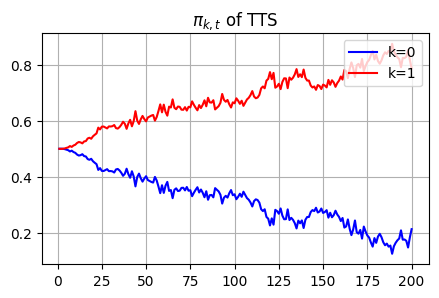

In [29]:
'''
TTS
'''
K = 2
n = 200
p = np.array([0.7,0.7])  # 각 arm을 선택했을 때 성공할 확률
p_m = np.array([0., 0.])

tts = TTS_missing(K, n, p, p_m)    
tts.run()

Phi_tts = pd.DataFrame(tts.phi_t, columns = ['k=0','k=1'])

data = [Phi_tts]
name = ['$\pi_{k,t}$ of TTS']

plt.figure(figsize=(5,3))
for i in range(1):
    x = np.arange(1,201)
    y1 = data[i]["k=0"][:200]
    y2 = data[i]["k=1"][:200]
    
    plt.subplot(1,1,i+1)
    plt.plot(x,y1,'b',label="k=0")
    plt.plot(x,y2,'r',label="k=1")
    
    plt.grid()
    plt.title(name[i])
    plt.legend(loc='upper right')

plt.show()

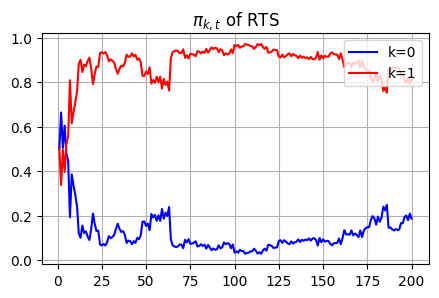

In [51]:
'''
RTS
'''
K = 2
n = 200
p = np.array([0.7,0.7])  # 각 arm을 선택했을 때 성공할 확률
p_m = np.array([0., 0.])

rts = RTS_missing(K, n, p, p_m)    
rts.run()

Phi_rts = pd.DataFrame(rts.phi_t, columns = ['k=0','k=1'])

data = [Phi_rts]
name = ['$\pi_{k,t}$ of RTS']

plt.figure(figsize=(5,3))
for i in range(1):
    x = np.arange(1,201)
    y1 = data[i]["k=0"][:200]
    y2 = data[i]["k=1"][:200]
    
    plt.subplot(1,1,i+1)
    plt.plot(x,y1,'b',label="k=0")
    plt.plot(x,y2,'r',label="k=1")
    
    plt.grid()
    plt.title(name[i])
    plt.legend(loc='upper right')

plt.show()

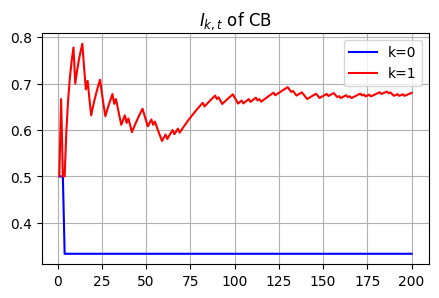

In [120]:
'''
CB
'''
K = 2
n = 200
p = np.array([0.7,0.7])  # 각 arm을 선택했을 때 성공할 확률
p_m = np.array([0., 0.])

cb = CB_missing(K, n, p, p_m)    
cb.run()

I_cb = pd.DataFrame(cb.I_t, columns = ['k=0','k=1'])

data = [I_cb]
name = ['$I_{k,t}$ of CB']

plt.figure(figsize=(5,3))
for i in range(1):
    x = np.arange(1,201)
    y1 = data[i]["k=0"][:200]
    y2 = data[i]["k=1"][:200]
    
    plt.subplot(1,1,i+1)
    plt.plot(x,y1,'b',label="k=0")
    plt.plot(x,y2,'r',label="k=1")
    
    plt.grid()
    plt.title(name[i])
    plt.legend(loc='upper right')

plt.show()

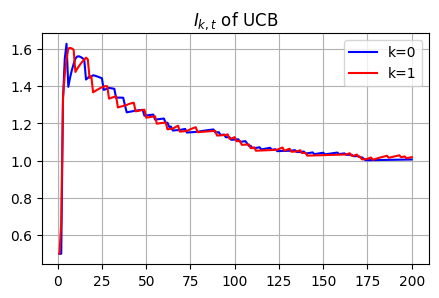

In [122]:
'''
UCB
'''
K = 2
n = 200
p = np.array([0.7,0.7])  # 각 arm을 선택했을 때 성공할 확률
p_m = np.array([0., 0.])

ucb = UCB_missing(K, n, p, p_m)    
ucb.run()

I_ucb = pd.DataFrame(ucb.I_t, columns = ['k=0','k=1'])

data = [I_ucb]
name = ['$I_{k,t}$ of UCB']

plt.figure(figsize=(5,3))
for i in range(1):
    x = np.arange(1,201)
    y1 = data[i]["k=0"][:200]
    y2 = data[i]["k=1"][:200]
    
    plt.subplot(1,1,i+1)
    plt.plot(x,y1,'b',label="k=0")
    plt.plot(x,y2,'r',label="k=1")
    
    plt.grid()
    plt.title(name[i])
    plt.legend(loc='upper right')

plt.show()

# 4. Simulation setting

In [6]:
data = {
    'p0' : [0.1, 0.5, 0.9, 0.1, 0.4, 0.7],
    'p1' : [0.1, 0.5, 0.9, 0.3, 0.6, 0.9],
    'n' : [200, 200, 200, 162, 254, 162]
}
indexname = ['S1', 'S3', 'S5', 'S7', 'S9', 'S11']
scenario = pd.DataFrame(data, index = indexname)
scenario.transpose()

,S1,S3,S5,S7,S9,S11
p0,0.1,0.5,0.9,0.1,0.4,0.7
p1,0.1,0.5,0.9,0.3,0.6,0.9
n,200.0,200.0,200.0,162.0,254.0,162.0


In [7]:
data = {
    'p0_m' : [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
    'p1_m' : [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5]
}
missing = pd.DataFrame(data)
missing.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
p0_m,0.0,0.1,0.2,0.3,0.4,0.5,0.0,0.1,0.2,0.3,0.4,0.5,0.0,0.0,0.0,0.0,0.0,0.0
p1_m,0.0,0.1,0.2,0.3,0.4,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.3,0.4,0.5


# 4. Run for missing

In [8]:
K = 2
n = scenario["n"]
p = np.array(scenario[["p0","p1"]])  # 각 arm을 선택했을 때 성공할 확률

pstar_matrix_missing = np.empty((0,9))

for j in range(6):
    print('S',2*j+1,':', sep = '')
    
    for k in range(18):
        print('p_m :',k, end= ' / ')

        p_m = np.array(missing[["p0_m","p1_m"]])[k]
        
        tts_pstar = 0
        rts_pstar = 0
        cb_pstar = 0
        ucb_pstar = 0

        episodes = 1000
        # Run experiments
        for i in range(episodes):
            # Initialize bandits
            tts = TTS_missing(K, n[j], p[j], p_m)
            rts = RTS_missing(K, n[j], p[j], p_m)

            # Run experiments
            tts.run()
            rts.run()

            # Average p*
            tts_pstar += (tts.pstar - tts_pstar) / (i + 1)
            rts_pstar += (rts.pstar - rts_pstar) / (i + 1)
            
        episodes = 10000
        # Run experiments
        for i in range(episodes):
            # Initialize bandits
            cb = CB_missing(K, n[j], p[j], p_m)    
            ucb = UCB_missing(K, n[j], p[j], p_m)    

            # Run experiments
            cb.run()
            ucb.run()

            # Average p*
            cb_pstar += (cb.pstar - cb_pstar) / (i + 1)
            ucb_pstar += (ucb.pstar - ucb_pstar) / (i + 1)
            
        pstar_matrix_missing = np.append(pstar_matrix_missing, 
                                 np.array([[round(p[j][0],2), round(p[j][1],2), n[j],
                                            round(p_m[0],2), round(p_m[1],2),
                                            round(tts_pstar,2), round(rts_pstar,2), round(cb_pstar,2), round(ucb_pstar,2)]]), axis=0)
    print('')
    
pstar_matrix_missing = pd.DataFrame(pstar_matrix_missing, columns = ['p0','p1','n','p0_m','p1_m', 'tts_p*', 'rts_p*', 'cb_p*', 'ucb_p*'])
pstar_matrix_missing.to_csv('data/pstar_matrix_missing_final.csv',index = False) 
pstar_matrix_missing

S1:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S3:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S5:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S7:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S9:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S11:
p_m : 0 / p_m : 1 / p_m : 2 / 

,p0,p1,n,p0_m,p1_m,tts_p*,rts_p*,cb_p*,ucb_p*
0,0.1,0.1,200.0,0.0,0.0,0.50,0.50,0.51,0.50
1,0.1,0.1,200.0,0.1,0.1,0.50,0.50,0.50,0.50
2,0.1,0.1,200.0,0.2,0.2,0.50,0.49,0.50,0.50
3,0.1,0.1,200.0,0.3,0.3,0.50,0.50,0.50,0.50
4,0.1,0.1,200.0,0.4,0.4,0.50,0.51,0.50,0.50
...,...,...,...,...,...,...,...,...,...
103,0.7,0.9,162.0,0.0,0.1,0.74,0.89,0.68,0.76
104,0.7,0.9,162.0,0.0,0.2,0.73,0.89,0.66,0.77
105,0.7,0.9,162.0,0.0,0.3,0.72,0.88,0.64,0.79
106,0.7,0.9,162.0,0.0,0.4,0.71,0.87,0.62,0.81


# 5. Run for Imputation

In [ ]:
pstar_matrix_missing = pd.read_csv("data/pstar_matrix_missing_final.csv")
pstar_matrix_imputation = pd.read_csv("data/pstar_matrix_imputation_final.csv")

In [9]:
K = 2
n = scenario["n"]
p = np.array(scenario[["p0","p1"]])  # 각 arm을 선택했을 때 성공할 확률

pstar_matrix_imputation = np.empty((0,9))

for j in range(6):
    print('S',2*j+1,':', sep = '')
    
    for k in range(18):
        print('p_m :',k, end= ' / ')

        p_m = np.array(missing[["p0_m","p1_m"]])[k]
        
        tts_pstar = 0
        rts_pstar = 0
        cb_pstar = 0
        ucb_pstar = 0

        episodes = 1000
        # Run experiments
        for i in range(episodes):
            # Initialize bandits
            tts = TTS_meanImputation(K, n[j], p[j], p_m)
            rts = RTS_meanImputation(K, n[j], p[j], p_m)

            # Run experiments
            tts.run()
            rts.run()

            # Average p*
            tts_pstar += (tts.pstar - tts_pstar) / (i + 1)
            rts_pstar += (rts.pstar - rts_pstar) / (i + 1)
            
        episodes = 10000
        # Run experiments
        for i in range(episodes):
            # Initialize bandits
            cb = CB_meanImputation(K, n[j], p[j], p_m)    
            ucb = UCB_meanImputation(K, n[j], p[j], p_m)    

            # Run experiments
            cb.run()
            ucb.run()

            # Average p*
            cb_pstar += (cb.pstar - cb_pstar) / (i + 1)
            ucb_pstar += (ucb.pstar - ucb_pstar) / (i + 1)
            
        pstar_matrix_imputation = np.append(pstar_matrix_imputation, 
                                 np.array([[round(p[j][0],2), round(p[j][1],2), n[j],
                                            round(p_m[0],2), round(p_m[1],2),
                                            round(tts_pstar,2), round(rts_pstar,2), round(cb_pstar,2), round(ucb_pstar,2)]]), axis=0)
    print('')
    
pstar_matrix_imputation = pd.DataFrame(pstar_matrix_imputation, columns = ['p0','p1','n','p0_m','p1_m', 'tts_p*', 'rts_p*', 'cb_p*', 'ucb_p*'])
pstar_matrix_imputation.to_csv('data/pstar_matrix_imputation_final.csv',index = False) 
pstar_matrix_imputation

S1:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S3:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S5:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S7:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S9:
p_m : 0 / p_m : 1 / p_m : 2 / p_m : 3 / p_m : 4 / p_m : 5 / p_m : 6 / p_m : 7 / p_m : 8 / p_m : 9 / p_m : 10 / p_m : 11 / p_m : 12 / p_m : 13 / p_m : 14 / p_m : 15 / p_m : 16 / p_m : 17 / 
S11:
p_m : 0 / p_m : 1 / p_m : 2 / 

,p0,p1,n,p0_m,p1_m,tts_p*,rts_p*,cb_p*,ucb_p*
0,0.1,0.1,200.0,0.0,0.0,0.50,0.50,0.50,0.50
1,0.1,0.1,200.0,0.1,0.1,0.50,0.51,0.50,0.50
2,0.1,0.1,200.0,0.2,0.2,0.50,0.50,0.50,0.50
3,0.1,0.1,200.0,0.3,0.3,0.50,0.49,0.50,0.50
4,0.1,0.1,200.0,0.4,0.4,0.50,0.50,0.50,0.50
...,...,...,...,...,...,...,...,...,...
103,0.7,0.9,162.0,0.0,0.1,0.74,0.88,0.66,0.75
104,0.7,0.9,162.0,0.0,0.2,0.74,0.88,0.63,0.75
105,0.7,0.9,162.0,0.0,0.3,0.74,0.86,0.61,0.75
106,0.7,0.9,162.0,0.0,0.4,0.74,0.83,0.58,0.74


# 6. Draw graph

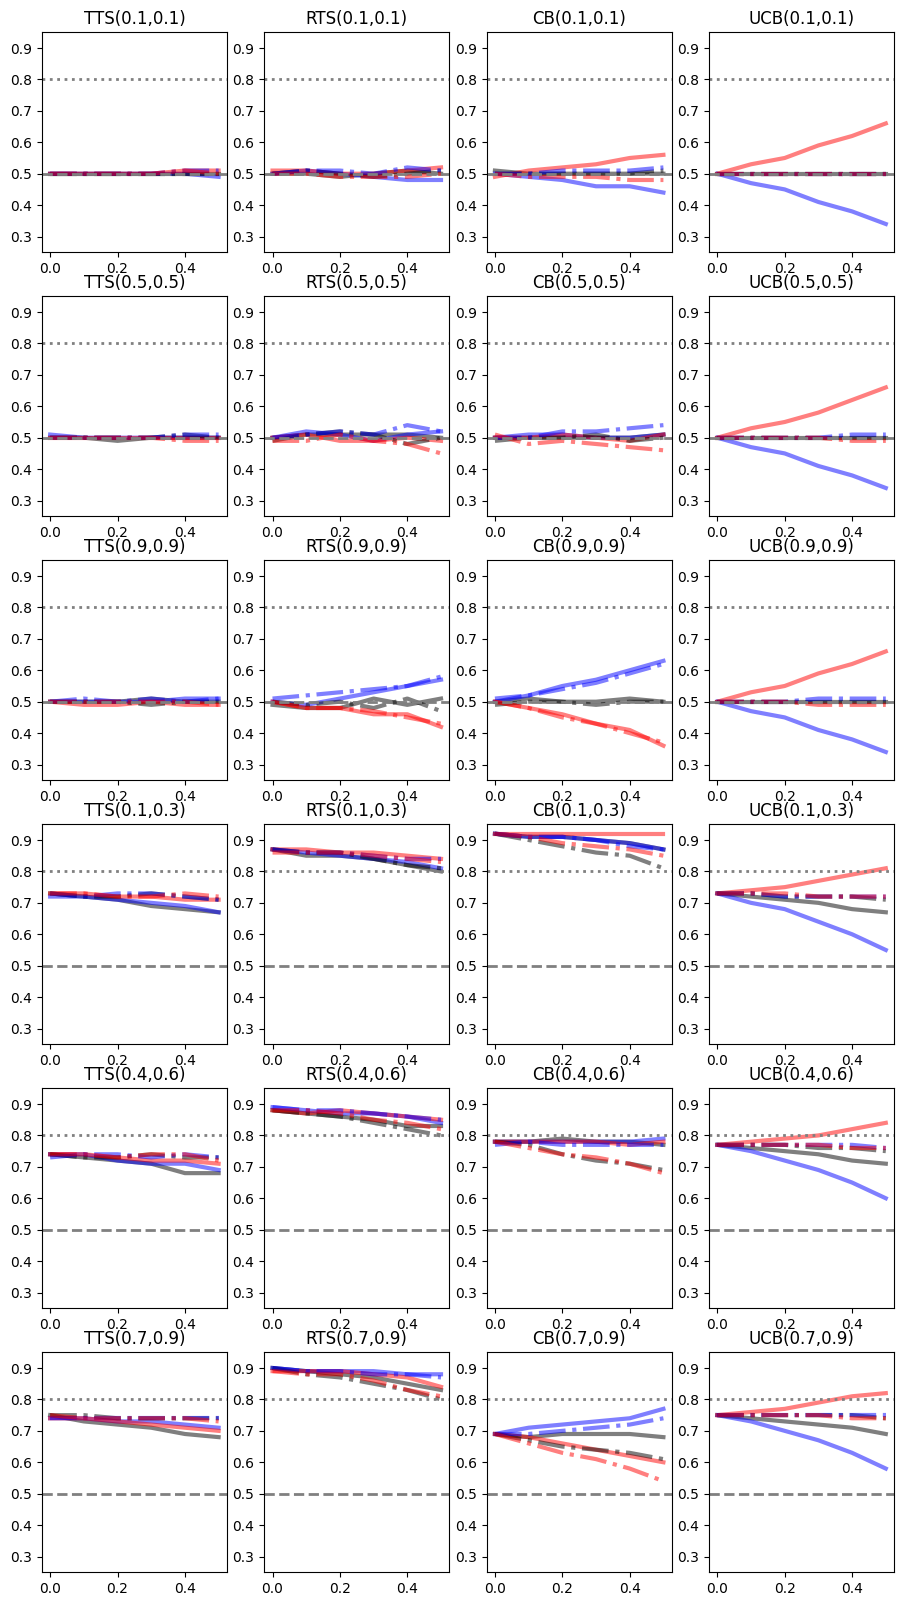

In [36]:
plt.figure(figsize=(11,20))
method = ['TTS','RTS','CB','UCB']
for j in range(6): 
    i = j*18
    tmp1_matrix = pstar_matrix_missing.iloc[i:i+18,:]
    tmp2_matrix = pstar_matrix_imputation.iloc[i:i+18,:]
    p0 = np.array(scenario[["p0","p1"]])[j][0]
    p1 = np.array(scenario[["p0","p1"]])[j][1]
    n = np.array(scenario[["n"]])[j][0]

    x = np.arange(0,0.6,0.1)
    y1 = tmp1_matrix.iloc[:6,]    #equal missing
    y2 = tmp1_matrix.iloc[6:12,]  #missing in po_m
    y3 = tmp1_matrix.iloc[12:,]   #missing in p1_m
    y4 = tmp2_matrix.iloc[:6,] 
    y5 = tmp2_matrix.iloc[6:12,]
    y6 = tmp2_matrix.iloc[12:,]
    
    for k in [1,2,3,4]:
        plt.subplot(6,4,j*4+k)
        plt.plot(x,y1.iloc[:,k+4],color = 'black',linewidth = 3.0,alpha=0.5,label="Equal probabilities of missing per arm $p^m$")
        plt.plot(x,y2.iloc[:,k+4],color = 'b',linewidth = 3.0,alpha=0.5,label="Probabilities of missing in $p_0^m$")
        plt.plot(x,y3.iloc[:,k+4],color = 'r',linewidth = 3.0,alpha=0.5,label="Probabilities of missing in $p_1^m$")
        plt.plot(x,y4.iloc[:,k+4],color = 'black',linestyle = '-.',linewidth = 3.0,alpha=0.5,label="Equal probabilities of missing per arm $p^m$")
        plt.plot(x,y5.iloc[:,k+4],color = 'b',linestyle = '-.',linewidth = 3.0,alpha=0.5,label="Probabilities of missing in $p_0^m$")
        plt.plot(x,y6.iloc[:,k+4],color = 'r',linestyle = '-.',linewidth = 3.0,alpha=0.5,label="Probabilities of missing in $p_1^m$")
        plt.ylim([0.25, 0.95])
        plt.title('%s(%s,%s)' % (method[k-1], p0, p1))
        plt.axhline(y = 0.8, color='gray', linestyle=':', linewidth=2)
        plt.axhline(y = 0.5, color='gray', linestyle='--', linewidth=2)

plt.show()